In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import nltk
import string
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the data
data = pd.read_csv('../data/labeled_data.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
class PreproTweets(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.preprocess_text(text) for text in X]

    def preprocess_text(self, text):
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\b\w{1,2}\b', '', text)  
        text = re.sub(r'[^\w\s]', '', text) 
        text = ' '.join(word for word in text.split() if word not in stop_words)
        return text

# Exemplo de pipeline com pré-processamento e TF-IDF
pipeline = Pipeline([
    ('prepro', PreproTweets()),
    ('tfidf', TfidfVectorizer()),
    ('nmf', NMF(n_components=30, random_state=42)),  # Adiciona NMF com 100 componentes
])

texts, target = data['tweet'], data['class']
texts_target = data[['tweet', 'class']]

pipeline.fit(texts)

Pipeline(steps=[('prepro', PreproTweets()), ('tfidf', TfidfVectorizer()),
                ('nmf', NMF(n_components=30, random_state=42))])

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

# Definição do Dataset personalizado
class TweetsDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels.values, dtype=torch.long)  # torch.long para classificações inteiras

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [12]:
import torch

class MyModel(torch.nn.Module):
    def __init__(self, input_size=100, num_classes=3):
        super(MyModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 64)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(64, 64)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(64, num_classes)
        # self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        # out = self.softmax(out)
        return out

In [13]:
X, y = pipeline.transform(texts), target
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)


In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15860, 30), (4957, 30), (15860,), (4957,))

In [15]:
model = MyModel(input_size=30)

In [16]:
# Sanity Check
model(torch.tensor(X[:2]).float())

tensor([[-0.0892, -0.0001,  0.1388],
        [-0.0846,  0.0047,  0.1362]], grad_fn=<AddmmBackward0>)

In [17]:

# Criando os Datasets
train_dataset = TweetsDataset(X_train, y_train)
test_dataset = TweetsDataset(X_test, y_test)

# Definindo os DataLoaders
batch_size = 16  # Ajuste conforme necessário

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
from torch import nn, optim

# Instanciando o modelo
input_size = X_train.shape[1]  # 100
num_classes = 3  # 0 e 1
model = MyModel(input_size=input_size, num_classes=num_classes)

# Verificar se CUDA está disponível e mover o modelo para GPU se possível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Usando o dispositivo: {device}")

# Definindo a função de perda e o otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Taxa de aprendizado ajustável

Usando o dispositivo: cpu


In [19]:
# Função para treinar o modelo
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=20):
    model.train()  # Define o modelo para modo de treino
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zerar os gradientes
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass e otimização
            loss.backward()
            optimizer.step()

            # Estatísticas
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total * 100

        print(f"Época {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Acurácia: {epoch_acc:.2f}%")

    print("Treinamento concluído.")

# Função para avaliar o modelo
def evaluate_model(model, test_loader, device):
    model.eval()  # Define o modelo para modo de avaliação
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total * 100
    print(f"Acurácia no Teste: {accuracy:.2f}%")
    return all_labels, all_preds

# Treinando o modelo
num_epochs = 10  # Ajuste conforme necessário
train_model(model, train_loader, criterion, optimizer, device, num_epochs=num_epochs)

# Avaliando o modelo
y_true, y_pred = evaluate_model(model, test_loader, device)

Época 1/10 - Loss: 0.5994 - Acurácia: 77.48%
Época 2/10 - Loss: 0.4082 - Acurácia: 84.52%
Época 3/10 - Loss: 0.3693 - Acurácia: 85.93%
Época 4/10 - Loss: 0.3551 - Acurácia: 86.49%
Época 5/10 - Loss: 0.3498 - Acurácia: 86.61%
Época 6/10 - Loss: 0.3478 - Acurácia: 86.80%
Época 7/10 - Loss: 0.3467 - Acurácia: 86.81%
Época 8/10 - Loss: 0.3458 - Acurácia: 86.92%
Época 9/10 - Loss: 0.3441 - Acurácia: 86.95%
Época 10/10 - Loss: 0.3434 - Acurácia: 87.04%
Treinamento concluído.
Acurácia no Teste: 87.11%


In [20]:
softmax = nn.Softmax(dim=1)
softmax(model(torch.tensor(X_test[:2]).float()))

tensor([[1.7438e-01, 8.2516e-01, 4.6705e-04],
        [5.1255e-02, 2.8464e-01, 6.6410e-01]], grad_fn=<SoftmaxBackward0>)

In [21]:
model(torch.tensor(X_test[:2]).float())

tensor([[ 0.6994,  2.2537, -5.2232],
        [-1.5847,  0.1297,  0.9769]], grad_fn=<AddmmBackward0>)

In [22]:
y.value_counts(normalize=True)

class
1    0.774321
2    0.167978
0    0.057701
Name: proportion, dtype: float64

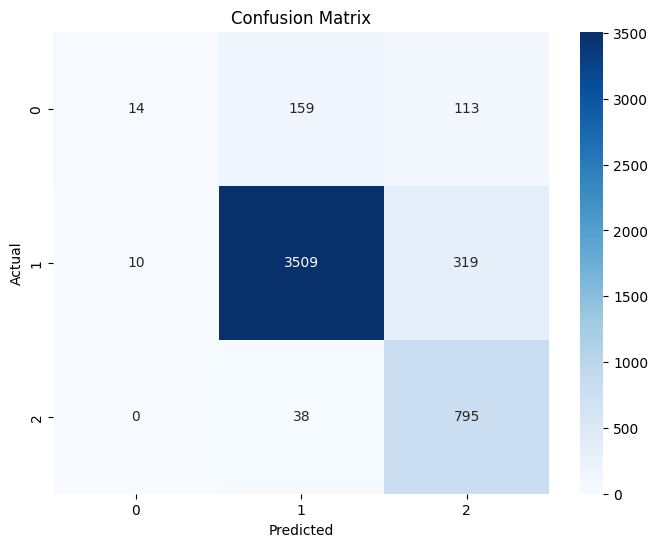

In [26]:
# confusion matrix 

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# precision, recall e f1-score

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.58      0.05      0.09       286
           1       0.95      0.91      0.93      3838
           2       0.65      0.95      0.77       833

    accuracy                           0.87      4957
   macro avg       0.73      0.64      0.60      4957
weighted avg       0.88      0.87      0.86      4957

